In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [32]:
data = pd.read_csv(r'C:\Users\shakt\stars_classification\Stars_classification_with_HR_diagram\Dataset\Stars.csv')

Dataset overview

In [33]:
data.columns

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

In [34]:
stellar_types = {
    0: 'Brown Dwarf',
    1: 'Red Dwarf', 
    2: 'White Dwarf',
    3: 'Main Sequence',
    4: 'Supergiant',
    5: 'Hypergiant'
}

data['Type_Name'] = data['Type'].map(stellar_types)

print("Dataset Overview:")
print(f"Shape: {data.shape}")
print(f"Classes: {data['Type'].nunique()}")
print(f"Class distribution:\n{data['Type_Name'].value_counts()}")
print()

Dataset Overview:
Shape: (240, 8)
Classes: 6
Class distribution:
Type_Name
Brown Dwarf      40
Red Dwarf        40
White Dwarf      40
Main Sequence    40
Supergiant       40
Hypergiant       40
Name: count, dtype: int64



In [35]:
numerical_features = ['Temperature', 'L', 'R', 'A_M']
X = data[numerical_features].copy()
y = data['Type'].copy()

In [36]:
print("Features used for prediction:")
for i, feature in enumerate(numerical_features):
    print(f"{i+1}. {feature}")
print()

Features used for prediction:
1. Temperature
2. L
3. R
4. A_M



In [37]:
print(f"Null values:\n{data.isnull().sum()}")

Null values:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
Type_Name         0
dtype: int64


In [38]:
print("Feature Statistics:")
print(X.describe())
print()

Feature Statistics:
        Temperature              L            R         A_M
count    240.000000     240.000000   240.000000  240.000000
mean   10497.462500  107188.361635   237.157781    4.382396
std     9552.425037  179432.244940   517.155763   10.532512
min     1939.000000       0.000080     0.008400  -11.920000
25%     3344.250000       0.000865     0.102750   -6.232500
50%     5776.000000       0.070500     0.762500    8.313000
75%    15055.500000  198050.000000    42.750000   13.697500
max    40000.000000  849420.000000  1948.500000   20.060000



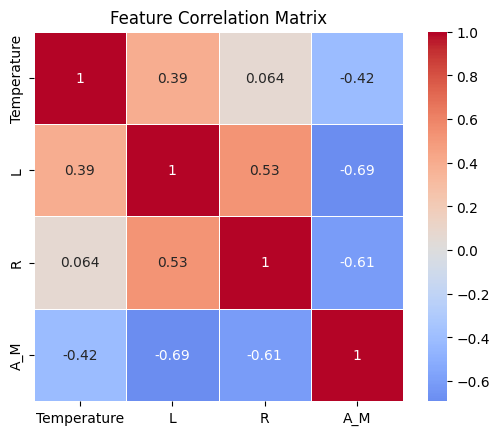

In [39]:
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Data preprocessing

In [40]:
X_processed = X.copy()

In [41]:
X_processed['L_log'] = np.log10(X_processed['L'] + 1e-10)  # Add small constant to avoid log(0)
X_processed = X_processed.drop('L', axis=1)

In [42]:
if X['R'].max() / X['R'].min() > 1000:  # Large range
    X_processed['R_log'] = np.log10(X_processed['R'] + 1e-10)
    X_processed = X_processed.drop('R', axis=1)

print("Processed features:", X_processed.columns.tolist())
print("Shape after preprocessing:", X_processed.shape)
print()

Processed features: ['Temperature', 'A_M', 'L_log', 'R_log']
Shape after preprocessing: (240, 4)



In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)


print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print()

Training set size: (192, 4)
Test set size: (48, 4)
Training class distribution:
Type
0    32
1    32
2    32
3    32
4    32
5    32
Name: count, dtype: int64



In [44]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print("Mean of scaled training features:", np.mean(X_train_scaled, axis=0).round(3))
print("Std of scaled training features:", np.std(X_train_scaled, axis=0).round(3))
print()

Feature scaling completed.
Mean of scaled training features: [ 0.  0.  0. -0.]
Std of scaled training features: [1. 1. 1. 1.]



In [45]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10)
}

In [46]:
results = {}
model_objects = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for models that benefit from it
    if name in ['SVM', 'Logistic Regression', 'K-Nearest Neighbors']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train the model
    model.fit(X_train_model, y_train)
    
    # predictions
    y_pred = model.predict(X_test_model)
    
    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='accuracy')
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    }
    
    model_objects[name] = model
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Training Random Forest...
Accuracy: 1.0000
Cross-validation: 1.0000 ± 0.0000

Training Gradient Boosting...
Accuracy: 1.0000
Cross-validation: 0.9741 ± 0.0281

Training SVM...
Accuracy: 0.9792
Cross-validation: 0.9845 ± 0.0127

Training Logistic Regression...
Accuracy: 0.9792
Cross-validation: 0.9744 ± 0.0324

Training K-Nearest Neighbors...
Accuracy: 0.9583
Cross-validation: 0.9792 ± 0.0104

Training Decision Tree...
Accuracy: 1.0000
Cross-validation: 0.9947 ± 0.0105


In [30]:
print(model_objects)

{'Random Forest': RandomForestClassifier(random_state=42), 'Gradient Boosting': GradientBoostingClassifier(random_state=42), 'SVM': SVC(probability=True, random_state=42), 'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42), 'K-Nearest Neighbors': KNeighborsClassifier(), 'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42)}


In [29]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

                     Accuracy  Precision  Recall  F1-Score  CV Mean  CV Std
Random Forest          1.0000     1.0000  1.0000    1.0000   1.0000  0.0000
Gradient Boosting      1.0000     1.0000  1.0000    1.0000   0.9741  0.0281
SVM                    0.9792     0.9815  0.9792    0.9791   0.9845  0.0127
Logistic Regression    0.9792     0.9815  0.9792    0.9791   0.9744  0.0324
K-Nearest Neighbors    0.9583     0.9667  0.9583    0.9577   0.9792  0.0104
Decision Tree          1.0000     1.0000  1.0000    1.0000   0.9947  0.0105


In [48]:
print("\nClassification Report:")
target_names = [stellar_types[i] for i in sorted(stellar_types.keys())]
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
               precision    recall  f1-score   support

  Brown Dwarf       1.00      1.00      1.00         8
    Red Dwarf       1.00      1.00      1.00         8
  White Dwarf       1.00      1.00      1.00         8
Main Sequence       1.00      1.00      1.00         8
   Supergiant       1.00      1.00      1.00         8
   Hypergiant       1.00      1.00      1.00         8

     accuracy                           1.00        48
    macro avg       1.00      1.00      1.00        48
 weighted avg       1.00      1.00      1.00        48



In [ ]:
def predict_stellar_type(temperature, luminosity, radius, absolute_magnitude):
    features = np.array([[temperature, luminosity, radius, absolute_magnitude]])
    feature_df = pd.DataFrame(features, columns=['Temperature', 'L', 'R', 'A_M'])
    RF = RandomForestClassifier(n_estimators=100, random_state=42)
    RF.fit(X_train, y_train)
    features_processed = feature_df.values
   
    if 'L_log' in X_processed.columns:
        feature_df['L_log'] = np.log10(feature_df['L'] + 1e-10)
        feature_df = feature_df.drop('L', axis=1)
    
    if 'R_log' in X_processed.columns:
        feature_df['R_log'] = np.log10(feature_df['R'] + 1e-10)
        feature_df = feature_df.drop('R', axis=1)
    
    prediction = RF.predict(features_processed)[0]
    probabilities = RF.predict_proba(features_processed)[0]
    
    
    stellar_type_name = stellar_types[prediction]
    confidence = probabilities[prediction]
    
    return stellar_type_name, confidence, probabilities

In [ ]:
stellar_type, confidence, probs = predict_stellar_type(5800, 1.0, 1.0, 4.83)
print(f"Predicted: {stellar_type} (confidence: {confidence:.3f})")

Predicted: Main Sequence (confidence: 0.390)
